In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision.utils import make_grid
from torch import flatten
import time
import sys
import os
import seaborn as sns

In [2]:
import seaborn as sns
import skimage.transform
from skimage import img_as_ubyte
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
### Fixing some values for the hyperparameters 
batch_size=50
epochs=10
criterion=nn.MSELoss()

In [4]:
## If GPU is abailable, then the code will be pushed to it otherwise it will move to CPU 
use_cuda=torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
##Loading the data
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
train_data = datasets.MNIST(root='../data', train=True,download=True, transform=transform)
test_data = datasets.MNIST(root='../data', train=False,download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

## ***Question 1***

## $PCA$

In [6]:
### Scaling data
train_data_pca = np.asarray(train_data.data)/255
test_data_pca = np.asarray(test_data.data)/255

flatten_data=test_data_pca.reshape(-1,784)

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse

In [8]:
pca_vec = PCA(n_components = 30) #first 30 eigenvalues
pca_vec.fit(flatten_data)
train_pca = pca_vec.transform(flatten_data)
reconstructed_data = pca_vec.inverse_transform(train_pca)
PCA_error = mse(flatten_data,reconstructed_data)
print('Reconstruction error is : ',PCA_error)

Reconstruction error is :  0.01753543473942351


## $Vanilla$ $Autoencoder$

In [6]:
class autoencoder(nn.Module):
    
    def __init__(self):
        super(autoencoder,self).__init__()
        
        ## Encoder module
        
        self.encoder = nn.Sequential(nn.Linear(784,512),nn.ReLU(),
                                     nn.Linear(512,256),nn.ReLU(),
                                     nn.Linear(256,128),nn.ReLU(),
                                     nn.Linear(128,30),nn.ReLU())
        ## Decoder module
        
        self.decoder = nn.Sequential(nn.Linear(30,128),nn.ReLU(),
                                     nn.Linear(128,256),nn.ReLU(),
                                     nn.Linear(256,784),nn.ReLU())
        
    def forward(self,x):
        x = flatten(x,1)
        encoded_output = self.encoder(x.float())
        decoded_output = self.decoder(encoded_output)
        
        return decoded_output,encoded_output
        

In [7]:
def train(model,device,train_loader,optimizer,train_loss,train_acc):
    model.train()
    acc=0
    train_l=0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output,_ = model(data)
        loss = criterion(output, flatten(data,1))
        loss.backward()
        optimizer.step()
        
        train_l+=loss.item()
        pred= output.argmax(dim=1, keepdim=True)
        acc+= pred.eq(target.view_as(pred)).sum().item()
        
    train_loss.append(train_l/len(train_loader.dataset))
    train_acc.append(100*acc/len(train_loader.dataset))

In [8]:
def test(model,device,test_loader,test_loss):
    model.eval()
    loss = 0
    acc = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output,_ = model(data)
            loss +=criterion(output, flatten(data,1)).data.item()  # sum up batch loss
            

    loss /= len(test_loader.dataset)
    test_loss.append(loss)
   

    #print('\nTest set: Average loss: {:.4f}'.format(loss))

In [9]:
vanilla_ae=autoencoder()
model=vanilla_ae.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [13]:
train_loss=[]
train_accuracy=[]
test_loss=[]
test_accuracy=[]
start=time.time()
for epoch in range(1,epochs+1):
    train(model,device,train_loader,optimizer,train_loss,train_accuracy)
    
    test(model, device, test_loader,test_loss)
end=time.time()

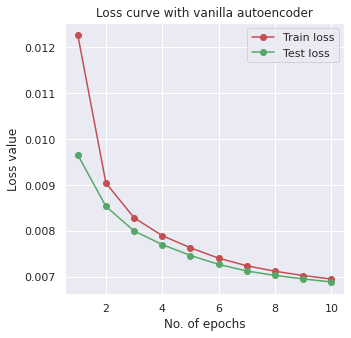

In [14]:
sns.set_theme()
plt.figure(figsize=(5, 5))
xval=np.arange(1,epochs+1,1)
plt.plot(xval,train_loss,color='r',marker='o')
plt.plot(xval,test_loss,color='g',marker='o')
plt.xlabel("No. of epochs")
plt.ylabel("Loss value")
plt.legend(["Train loss","Test loss"])
plt.title("Loss curve with vanilla autoencoder")
plt.grid(True)

In [15]:
def random_plotting_of_test_images(network,test_loader):
    image_index= np.random.randint(low=0, high=9999) #test set has 10000 images
    
    val=test_loader.dataset.targets
    test_image_id=int(val[image_index].detach().cpu().numpy())
    
    test_image = test_loader.dataset.data[image_index].clone()
    with torch.no_grad():#Using no_grad as it reduces memory consumption for computation.
        test_image = test_image.reshape(1,1,28,28).cuda().float()
        out,_ = network.forward(test_image)
    
    ##From PCA
    pca_image=reconstructed_data[image_index,:]
    
    f,axarr=plt.subplots(1,2,figsize=(8, 8))
    axarr[0].imshow(pca_image.reshape(28,28),cmap='viridis')
    axarr[0].axis('off')
    axarr[0].set_title(f"Reconstruction of  {test_image_id} from PCA")
    axarr[1].imshow(out.detach().cpu().numpy().reshape(28,28),cmap='viridis')
    axarr[1].axis('off')
    axarr[1].set_title(f"Reconstruction of  {test_image_id} from Autoencoder")

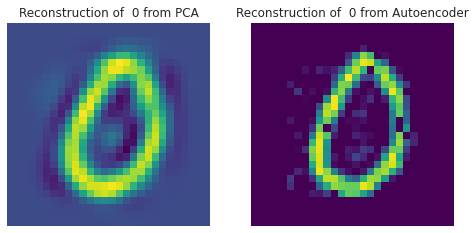

In [126]:
random_plotting_of_test_images(model,test_loader)

## ***Question 2***

In [97]:
class autoencoder_q2(nn.Module):
    
    def __init__(self,hidden_layer):
        super(autoencoder_q2,self).__init__()
        
        ## Encoder module
        
        self.encoder = nn.Sequential(nn.Linear(784,hidden_layer),nn.ReLU())
        
        ## Decoder module
        
        self.decoder = nn.Sequential(nn.Linear(hidden_layer,784),nn.ReLU())
        
    def forward(self,x):
        x = flatten(x,1)
        encoded_output = self.encoder(x.float())
        decoded_output = self.decoder(encoded_output)
        
        return decoded_output,encoded_output
        

In [11]:
x=[64,128,256]
i=0
ae=autoencoder_q2(x[i])
model_q2=ae.to(device)
optimizer = optim.Adam(model_q2.parameters(), lr=0.0001)


In [35]:
train_loss=[]
train_accuracy=[]
test_loss=[]

for epoch in range(1,epochs+1):
    train(model_q2,device,train_loader,optimizer,train_loss,train_accuracy)

    test(model_q2, device, test_loader,test_loss)

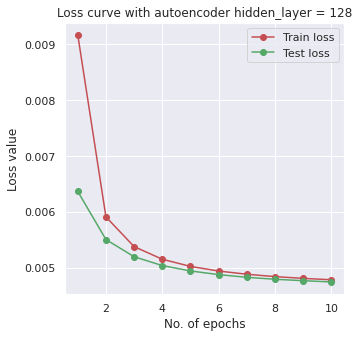

In [78]:
sns.set_theme()
plt.figure(figsize=(5, 5))
xval=np.arange(1,epochs+1,1)
plt.plot(xval,train_loss,color='r',marker='o')
plt.plot(xval,test_loss,color='g',marker='o')
plt.xlabel("No. of epochs")
plt.ylabel("Loss value")
plt.legend(["Train loss","Test loss"])
plt.title(f"Loss curve with autoencoder hidden_layer = {x[i]}")
plt.grid(True)

Text(0.5, 1.0, 'Randomly chosen \n Reconstructed image with hidden_layer = 256')

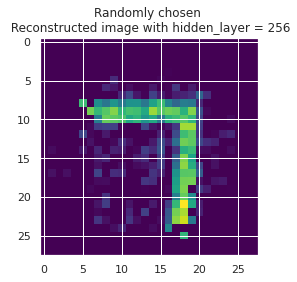

In [24]:
### Trying diffrent hidden layer on one image of test_set

image_index= np.random.randint(low=0, high=9999) #test set has 10000 images
    
val = test_loader.dataset.targets
test_image_id = int(val[image_index].detach().cpu().numpy())

test_image = test_loader.dataset.data[image_index].clone()

with torch.no_grad():#Using no_grad as it reduces memory consumption for computation.
        test_image = test_image.reshape(1,1,28,28).cuda().float()
        out,_ = model_q2.forward(test_image)
        
plt.imshow(out.detach().cpu().numpy().reshape(28,28),cmap='viridis')
plt.title(f"Randomly chosen \n Reconstructed image with hidden_layer = {x[i]}")

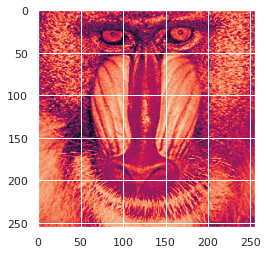

In [79]:
import cv2
img=cv2.imread("mandril.png")
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(img)

In [80]:
new_img = np.asarray(img)
rescaled_image= torch.from_numpy(img_as_ubyte(skimage.transform.resize(new_img,(28,28)))) ##resizing it to 28*28
noise_input=torch.from_numpy(np.random.normal(0, 1, size=(1,1,28,28))).cuda().float()
with torch.no_grad():#Using no_grad as it reduces memory consumption for computation.
        rescaled_image = rescaled_image.reshape(1,1,28,28).cuda().float()
        out_mandril,_ = model_q2.forward(rescaled_image)
        out_noise,_= model_q2.forward(noise_input)

Text(0.5, 1.0, 'Reconstruction of mandril from Autoencoder\n hidden_layer=128')

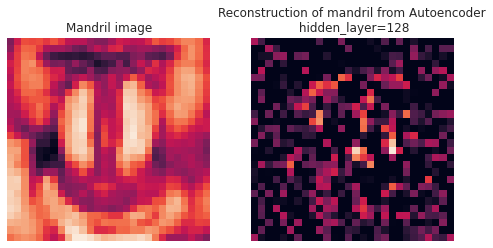

In [81]:
f,axarr=plt.subplots(1,2,figsize=(8, 8))
axarr[0].imshow(rescaled_image.detach().cpu().numpy().reshape(28,28))
axarr[0].axis('off')
axarr[0].set_title(f"Mandril image")
axarr[1].imshow(out_mandril.detach().cpu().numpy().reshape(28,28))
axarr[1].axis('off')
axarr[1].set_title(f"Reconstruction of mandril from Autoencoder\n hidden_layer={x[i]}")

Text(0.5, 1.0, 'Reconstruction of noise from Autoencoder\n hidden_layer=128')

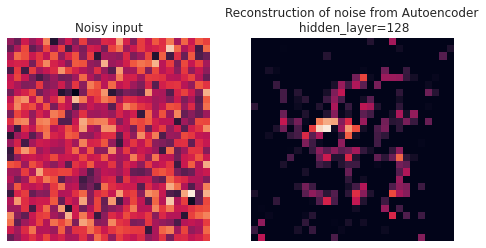

In [82]:
f,axarr=plt.subplots(1,2,figsize=(8, 8))
axarr[0].imshow(noise_input.detach().cpu().numpy().reshape(28,28))
axarr[0].axis('off')
axarr[0].set_title(f"Noisy input")
axarr[1].imshow(out_noise.detach().cpu().numpy().reshape(28,28))
axarr[1].axis('off')
axarr[1].set_title(f"Reconstruction of noise from Autoencoder\n hidden_layer={x[i]}")

## ***Question 3***

In [24]:
class autoencoder_q3(nn.Module):
    
    def __init__(self):
        super(autoencoder_q3,self).__init__()
        
        ## Encoder module
        
        self.encoder = nn.Sequential(nn.Linear(784,900),nn.ReLU())
        
        ## Decoder module
        
        self.decoder = nn.Sequential(nn.Linear(900,784),nn.ReLU())
        
    def forward(self,x):
        x = flatten(x,1)
        encoded_output = self.encoder(x.float())
        decoded_output = self.decoder(encoded_output)
        
        return decoded_output,encoded_output

In [25]:
def train_sparse(model,device,reg,train_loader,optimizer,train_loss,train_acc):
    model.train()
    acc=0
    train_l=0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output,encoded = model(data)
        loss = criterion(output, flatten(data,1))
        loss += reg*torch.linalg.norm(encoded,1) #added L1 penalty term
        loss.backward()
        optimizer.step()
        
        train_l+=loss.item()
        pred= output.argmax(dim=1, keepdim=True)
        acc+= pred.eq(target.view_as(pred)).sum().item()
        
    train_loss.append(train_l/len(train_loader.dataset))
    train_acc.append(100*acc/len(train_loader.dataset))

In [26]:
def test_sparse(model,device,reg,test_loader,test_loss):
    model.eval()
    tloss = 0
    acc = 0
    loss=0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output,encoded = model(data)
            loss = criterion(output, flatten(data,1))
            loss += reg*torch.linalg.norm(encoded,1) #added L1 penalty term
            tloss +=loss.data.item()  # sum up batch loss
            

    tloss /= len(test_loader.dataset)
    test_loss.append(tloss)

In [27]:
ae_q3=autoencoder_q3()
model_q3=ae_q3.to(device)
optimizer = optim.Adam(model_q3.parameters(), lr=0.0001)

In [49]:
train_loss=[]
train_accuracy=[]
test_loss=[]
reg=0.001
for epoch in range(1,epochs+1):
    train_sparse(model_q3,device,reg,train_loader,optimizer,train_loss,train_accuracy)

    test_sparse(model_q3, device,reg,test_loader,test_loss)

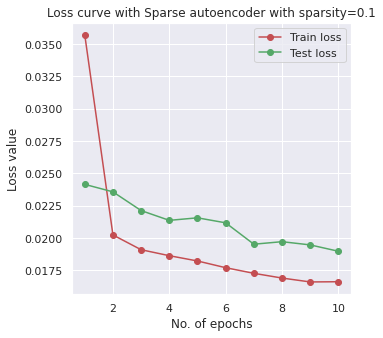

In [173]:
sns.set_theme()
plt.figure(figsize=(5, 5))
xval=np.arange(1,epochs+1,1)
plt.plot(xval,train_loss,color='r',marker='o')
plt.plot(xval,test_loss,color='g',marker='o')
plt.xlabel("No. of epochs")
plt.ylabel("Loss value")
plt.legend(["Train loss","Test loss"])
plt.title(f"Loss curve with Sparse autoencoder with sparsity={reg}")
plt.grid(True)

In [13]:
def average_activation_sparse(model,device,test_loader):
    model.eval()
    
    average_activation=0
    
    with torch.no_grad():
        
        
        for (data,label) in test_loader: 
            
            data,label = data.to(device),label.to(device) 
        
            reconstruction,encoded = model(data) 
                    
            average_activation += float(torch.mean(encoded))        
                
        
        
    average_activation    /= len(test_loader.dataset)
    
    print('The average activation norm is ',average_activation)
            
    

In [174]:
### Average activation for Sparse autoencoder, with sparsity 0.001,0.01,0.1
average_activation_sparse(model_q3,device,test_loader)
## For 0.001=0.005324395973980427, 0.01=0.0009793924264609813, 0.1=0.00013127546962350608

The average activation norm is  0.00013127546962350608


In [21]:
average_activation_sparse(model_q2,device,test_loader)

The average activation norm is  0.07290675175189971


In [22]:
### Average activation for standard autoencoder

## h=64, avg_acti= 0.13396140904426573

## h=128, avg_acti= 0.10157207226753234

## h=256, avg_acti= 0.07290675175189971

In [50]:
def visalize_output(model,test_loader):
    image_idx=[13,5,1,18,6,8,11,0,61,12]
    indices=1 ##digit 2
    
    test_image = test_loader.dataset.data[indices].clone()  
    test_image = test_image.reshape(1,1,28,28).cuda().float() 

    with torch.no_grad():
        reconstructed_image,encoded_img = model.forward(test_image)
        reconstructed_image = reconstructed_image.detach().cpu().numpy()
        plt.imshow(reconstructed_image.reshape(28,28))
        plt.title("Output of digit 2 for sparsity 0.001")
        
        
        

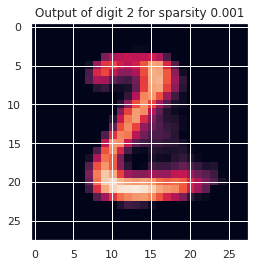

In [51]:
visalize_output(model_q3,test_loader)

In [52]:
def visalize_activations(model,test_loader):
    image_idx=[13,5,1,18,6,8,11,0,61,12]
    indices=1 ##digit 2
    
    test_image = test_loader.dataset.data[indices].clone()  
    test_image = test_image.reshape(1,1,28,28).cuda().float() 

    with torch.no_grad():
        reconstructed_image,encoded_img = model.forward(test_image)
        encoded_img = encoded_img.detach().cpu().numpy()
        plt.imshow(encoded_img.reshape(int(np.sqrt(900)),int(np.sqrt(900))))
        plt.title("Activations of digit 2 for sparsity 0.001")

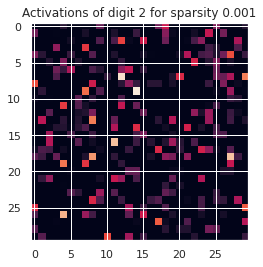

In [53]:
visalize_activations(model_q3,test_loader)

In [108]:
def visualize_filter(model):
    with torch.no_grad():
        
        encoder_filters = model.encoder[0].weight.detach().cpu().numpy()
        decoder_filters = model.decoder[0].weight.detach().cpu().numpy()
        
        neuron_index=3## chosen in a whim
        
        f,axarr=plt.subplots(1,2,figsize=(8, 8))
        axarr[0].imshow(encoder_filters[neuron_index].reshape(28,28),cmap='GnBu')
        axarr[0].axis('off')
        axarr[0].set_title(f"Encoder filter for {neuron_index}rd neuron\n noise_level=0.3")
        axarr[1].imshow(decoder_filters[:,neuron_index].reshape(28,28),cmap='GnBu')
        axarr[1].axis('off')
        axarr[1].set_title(f"Decoder filter for {neuron_index}rd neuron\n noise_level=0.3")
        
        

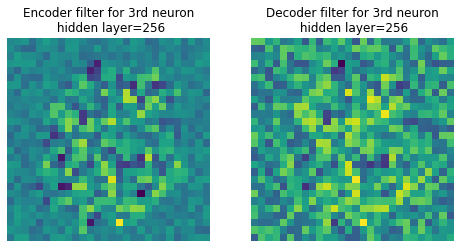

In [37]:
visualize_filter(model_q2)

## ***Question 4***

In [98]:
#### In denoisng autoencoder the hidden layer size is 256, and during train and test noisy images are to be send.
ae_q4=autoencoder_q2(256)
model_q4=ae_q4.to(device)
optimizer = optim.Adam(model_q4.parameters(), lr=0.0001)

In [99]:
def adding_noise(data,noise_level):
    ## Adding gaussian noise
    noise=(torch.randn(data.size())*noise_level).to(device)
    noisy_data=noise+data
    return noisy_data

In [100]:
def train_denoising(model,device,noise_level,train_loader,optimizer,train_loss,train_acc):
    model.train()
    acc=0
    train_l=0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        noisy_input=adding_noise(data,noise_level)
        optimizer.zero_grad()
        output,encoded = model(noisy_input)
        loss = criterion(output, flatten(data,1))
        loss.backward()
        optimizer.step()
        
        train_l+=loss.item()
        pred= output.argmax(dim=1, keepdim=True)
        acc+= pred.eq(target.view_as(pred)).sum().item()
        
    train_loss.append(train_l/len(train_loader.dataset))
    train_acc.append(100*acc/len(train_loader.dataset))

In [101]:
def test_denoising(model,device,noise_level,test_loader,test_loss):
    model.eval()
    loss = 0
    acc = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            noisy_input=adding_noise(data,noise_level)            
            output,_ = model(noisy_input)
            loss +=criterion(output, flatten(data,1)).data.item()  # sum up batch loss
            

    loss /= len(test_loader.dataset)
    test_loss.append(loss)

In [105]:
train_loss=[]
train_accuracy=[]
test_loss=[]
noise_level=0.5
for epoch in range(1,epochs+1):
    train_denoising(model_q4,device,noise_level,train_loader,optimizer,train_loss,train_accuracy)

    test_denoising(model_q4, device,noise_level, test_loader,test_loss)

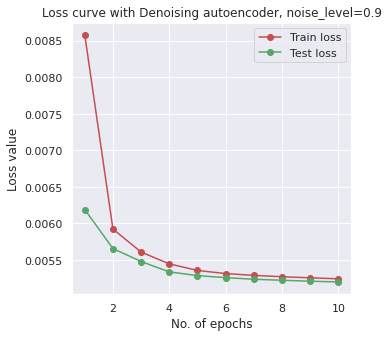

In [85]:
sns.set_theme()
plt.figure(figsize=(5, 5))
xval=np.arange(1,epochs+1,1)
plt.plot(xval,train_loss,color='r',marker='o')
plt.plot(xval,test_loss,color='g',marker='o')
plt.xlabel("No. of epochs")
plt.ylabel("Loss value")
plt.legend(["Train loss","Test loss"])
plt.title(f"Loss curve with Denoising autoencoder, noise_level=0.9")
plt.grid(True)

In [108]:
def visalize_output(model,test_loader):
    image_idx=[13,5,1,18,6,8,11,0,61,12]
    indices=1 ##digit 2
    
    test_image = test_loader.dataset.data[indices].clone()  
    test_image = test_image.reshape(1,1,28,28).cuda().float() 

    with torch.no_grad():
        reconstructed_image,encoded_img = model.forward(test_image)
        reconstructed_image = reconstructed_image.detach().cpu().numpy()
        plt.imshow(reconstructed_image.reshape(28,28))
        plt.title("Output of digit 2 for noise_level=0.9")
        

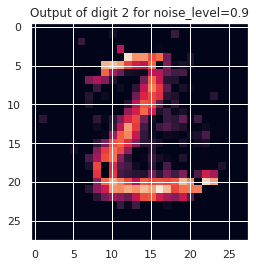

In [109]:
visalize_output(model_q4,test_loader)

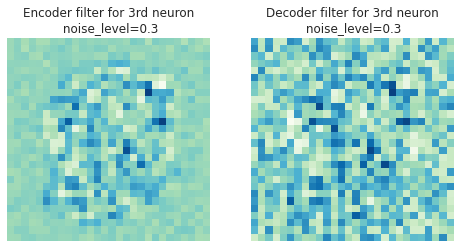

In [109]:
visualize_filter(model_q4)

## ***Question 5***

In [6]:
class conv_AE_unpool(nn.Module): #define unpooling outside the decoder and separately in forward nn.Sequential just takes one input
    
    def __init__(self): #class constructor
        super(conv_AE_unpool,self).__init__() #calls the parent constructor
        
        #initializing the encoder module
        self.encoder_conv1 = nn.Sequential(nn.Conv2d(1,8, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2),return_indices = True)) # 28x28x1 to 14x14x8
        self.encoder_conv2 = nn.Sequential(nn.Conv2d(8,16, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2),return_indices = True)) #14x14x8 to 7x7x16
        self.encoder_conv3 = nn.Sequential(nn.Conv2d(16,16, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2),return_indices = True)) #7x7x16 to 3x3x16
        
        #initializing the decoder module
        self.decoder_conv1 = nn.Sequential(nn.Identity()) #7x7x16 to 7x7x16
        self.decoder_conv2 = nn.Sequential(nn.Conv2d(16,8, kernel_size = 3, stride = 1,padding= 1),nn.ReLU()) #14x14x16 to 14x14x8
        self.decoder_conv3 = nn.Sequential(nn.Conv2d(8,1, kernel_size = 3, stride = 1,padding= 1),nn.ReLU()) #28x28x8 to 28x28x1
        
        #defining the unpooling operation
        self.unpool = nn.MaxUnpool2d(kernel_size = (2,2))
        
        
    def forward(self,x): #defines the forward pass and also the structure of the network thus helping backprop
        
        encoded_input,indices1  = self.encoder_conv1(x.float())  # 28x28x1 to 14x14x8
        encoded_input,indices2  = self.encoder_conv2(encoded_input) #14x14x8 to 7x7x16
        encoded_input,indices3  = self.encoder_conv3(encoded_input) #7x7x16 to 3x3x16
        
        
        reconstructed_input     = self.unpool(encoded_input,indices3,output_size=torch.Size([batch_size, 16, 7, 7])) #3x3x16 to 7x7x16
        reconstructed_input     = self.decoder_conv1(reconstructed_input) #7x7x16 to 7x7x16
        reconstructed_input     = self.unpool(reconstructed_input,indices2) #7x7x16 to 14x14x16
        reconstructed_input     = self.decoder_conv2(reconstructed_input)#14x14x16 to 14x14x8
        reconstructed_input     = self.unpool(reconstructed_input,indices1)#14x14x8 to 28x28x8
        reconstructed_input     = self.decoder_conv3(reconstructed_input)#28x28x8 to 28x28x1

        
        return reconstructed_input,encoded_input

In [7]:
class conv_AE_deconv(nn.Module):
    def __init__(self): #class constructor
        super(conv_AE_deconv,self).__init__() #calls the parent constructor
        
        #initializing the encoder module
        self.encoder_conv1 = nn.Sequential(nn.Conv2d(1,8, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2)))
        self.encoder_conv2 = nn.Sequential(nn.Conv2d(8,16, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2)))
        self.encoder_conv3 = nn.Sequential(nn.Conv2d(16,16, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2)))
        
        #initializing the decoder module
        self.decoder_conv1 = nn.Sequential(nn.ConvTranspose2d(16,16, kernel_size = 3, stride = 2),nn.ReLU())
        self.decoder_conv2 = nn.Sequential(nn.ConvTranspose2d(16,8, kernel_size = 4, stride = 2, padding = 1),nn.ReLU())
        self.decoder_conv3 = nn.Sequential(nn.ConvTranspose2d(8,1, kernel_size = 4, stride = 2, padding = 1),nn.ReLU())
        
    def forward(self,x): #defines the forward pass and also the structure of the network thus helping backprop
        
        encoded_input  = self.encoder_conv1(x.float())
        encoded_input  = self.encoder_conv2(encoded_input)
        encoded_input  = self.encoder_conv3(encoded_input)

        reconstructed_input     = self.decoder_conv1(encoded_input)
        reconstructed_input     = self.decoder_conv2(reconstructed_input)
        reconstructed_input     = self.decoder_conv3(reconstructed_input)

        return reconstructed_input,encoded_input

In [8]:
class conv_AE_deconv_unpool(nn.Module):
    def __init__(self): #class constructor
        super(conv_AE_deconv_unpool,self).__init__() #calls the parent constructor
        
         #initializing the encoder module
        self.encoder_conv1 = nn.Sequential(nn.Conv2d(1,8, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2),return_indices = True))
        self.encoder_conv2 = nn.Sequential(nn.Conv2d(8,16, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2),return_indices = True))
        self.encoder_conv3 = nn.Sequential(nn.Conv2d(16,16, kernel_size = 3, stride = 1,padding= 1),nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2),return_indices = True))
        
        #initializing the decoder module
        self.decoder_conv1 = nn.Sequential(nn.ConvTranspose2d(16,16, kernel_size = 3, stride = 1, padding = 1),nn.ReLU())
        self.decoder_conv2 = nn.Sequential(nn.ConvTranspose2d(16,8, kernel_size = 3, stride = 1, padding = 1),nn.ReLU())
        self.decoder_conv3 = nn.Sequential(nn.ConvTranspose2d(8,1, kernel_size = 3, stride = 1, padding = 1),nn.ReLU())
        
        #defining the unpooling operation
        self.unpool = nn.MaxUnpool2d(kernel_size = (2,2))
        
    def forward(self,x): #defines the forward pass and also the structure of the network thus helping backprop
        
        encoded_input,indices1  = self.encoder_conv1(x.float())
        encoded_input,indices2  = self.encoder_conv2(encoded_input)
        encoded_input,indices3  = self.encoder_conv3(encoded_input)
        
        
        reconstructed_input     = self.unpool(encoded_input,indices3,output_size=torch.Size([batch_size, 16, 7, 7]))
        reconstructed_input     = self.decoder_conv1(reconstructed_input)
        reconstructed_input     = self.unpool(reconstructed_input,indices2)
        reconstructed_input     = self.decoder_conv2(reconstructed_input)
        reconstructed_input     = self.unpool(reconstructed_input,indices1)
        reconstructed_input     = self.decoder_conv3(reconstructed_input)
        
        
        return reconstructed_input,encoded_input    

In [9]:
def train_conv_AE(model,device,optimizer,train_loader,train_loss):
    model.train()
    acc=0
    train_l=0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output,_ = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        
        train_l+=loss.item()
        #pred= output.argmax(dim=1, keepdim=True)
        #acc+= pred.eq(target.view_as(pred)).sum().item()
        
    train_loss.append(train_l/len(train_loader.dataset))
    #train_acc.append(100*acc/len(train_loader.dataset))

In [10]:
def test_conv_AE(model,device,optimizer,test_loader,test_loss):
    model.eval()
    loss = 0
    acc = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output,_ = model(data)
            loss +=criterion(output, data).data.item()  # sum up batch loss
            

    loss /= len(test_loader.dataset)
    test_loss.append(loss)

In [11]:
ae_q5_unpool=conv_AE_unpool()
model_q5_unpool=ae_q5_unpool.to(device)
optimizer_unpool=optim.Adam(model_q5_unpool.parameters(), lr=0.0001)

ae_q5_deconv=conv_AE_deconv()
model_q5_deconv=ae_q5_deconv.to(device)
optimizer_deconv=optim.Adam(model_q5_deconv.parameters(), lr=0.0001)

ae_q5_deconv_unpool=conv_AE_deconv_unpool()
model_q5_deconv_unpool=ae_q5_deconv_unpool.to(device)
optimizer_deconv_unpool=optim.Adam(model_q5_deconv_unpool.parameters(), lr=0.0001)

In [12]:
train_loss=[]
train_accuracy=[]
test_loss=[]
for i in range(1,epochs+1):
    train_conv_AE(model_q5_unpool,device,optimizer_unpool,train_loader,train_loss)
    test_conv_AE(model_q5_unpool,device,optimizer_unpool,test_loader,test_loss)

/home/htic/GE_APW/lib/python3.8/site-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


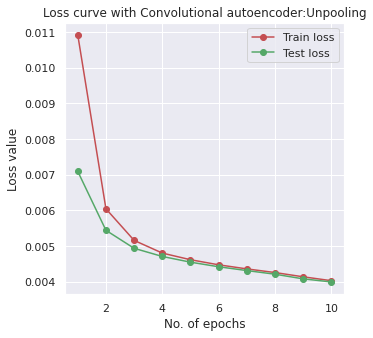

In [13]:
sns.set_theme()
plt.figure(figsize=(5, 5))
xval=np.arange(1,epochs+1,1)
plt.plot(xval,train_loss,color='r',marker='o')
plt.plot(xval,test_loss,color='g',marker='o')
plt.xlabel("No. of epochs")
plt.ylabel("Loss value")
plt.legend(["Train loss","Test loss"])
plt.title(f"Loss curve with Convolutional autoencoder:Unpooling")
plt.grid(True)

In [14]:
train_loss=[]
train_accuracy=[]
test_loss=[]
for i in range(1,epochs+1):
    train_conv_AE(model_q5_deconv,device,optimizer_deconv,train_loader,train_loss)
    test_conv_AE(model_q5_deconv,device,optimizer_deconv,test_loader,test_loss)

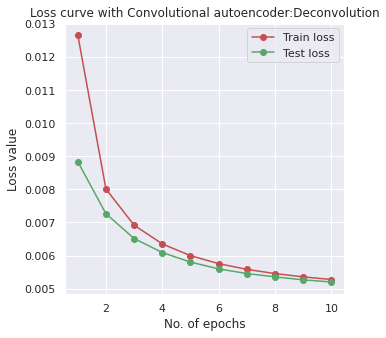

In [134]:
sns.set_theme()
plt.figure(figsize=(5, 5))
xval=np.arange(1,epochs+1,1)
plt.plot(xval,train_loss,color='r',marker='o')
plt.plot(xval,test_loss,color='g',marker='o')
plt.xlabel("No. of epochs")
plt.ylabel("Loss value")
plt.legend(["Train loss","Test loss"])
plt.title(f"Loss curve with Convolutional autoencoder:Deconvolution")
plt.grid(True)

In [15]:
train_loss=[]
train_accuracy=[]
test_loss=[]
for i in range(1,epochs+1):
    train_conv_AE(model_q5_deconv_unpool,device,optimizer_deconv_unpool,train_loader,train_loss)
    test_conv_AE(model_q5_deconv_unpool,device,optimizer_deconv_unpool,test_loader,test_loss)

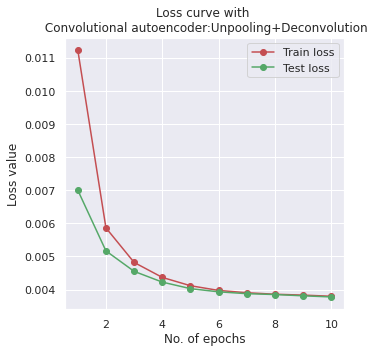

In [136]:
sns.set_theme()
plt.figure(figsize=(5, 5))
xval=np.arange(1,epochs+1,1)
plt.plot(xval,train_loss,color='r',marker='o')
plt.plot(xval,test_loss,color='g',marker='o')
plt.xlabel("No. of epochs")
plt.ylabel("Loss value")
plt.legend(["Train loss","Test loss"])
plt.title(f"Loss curve with \n Convolutional autoencoder:Unpooling+Deconvolution")
plt.grid(True)

In [153]:
def visalize_convoutput(model):
    image_idx=[13,5,1,18,6,8,11,0,61,12]
    indices=1 ##digit 2
    
    test_image = test_loader.dataset.data[indices].clone()  
    test_image = test_image.reshape(1,1,28,28).cuda().float() 
    
    with torch.no_grad():
        reconstructed_image,encoded_img = model.forward(test_image)
        reconstructed_image = reconstructed_image.detach().cpu().numpy()
        test_image=test_image.detach().cpu().numpy()
        
        f,axarr=plt.subplots(1,2,figsize=(8, 8))
        axarr[0].imshow(test_image.reshape(28,28),cmap='Purples')
        axarr[0].axis('off')
        axarr[0].set_title(f"Original Image")
        axarr[1].imshow(reconstructed_image.reshape(28,28),cmap='Purples')
        axarr[1].axis('off')
        axarr[1].set_title(f"Reconstructed output:\n unpooling")
        
        

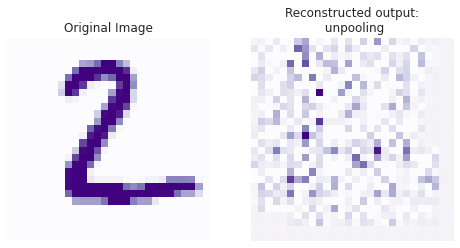

In [154]:
visalize_convoutput(model_q5_unpool)

In [94]:
def visualize_deconv_filter(model,decoder_weights):

    decoder_weights=decoder_weights.cpu()
    decoder_weights -= decoder_weights.min()
    decoder_weights /= decoder_weights.max()
    
    (x,y,z,w) = decoder_weights.shape
    
    channel = np.random.randint(0 ,x ,3)
    
    for idx in channel:
        weight= make_grid(decoder_weights[idx].reshape(y,1,z,w))
        weight=weight.permute(1,2,0)
        plt.imshow(weight)
        plt.title(f"Deconvolution+Unpooling Model Weights: Deconv layer=3 of channel {idx}")
        plt.show()
    
    

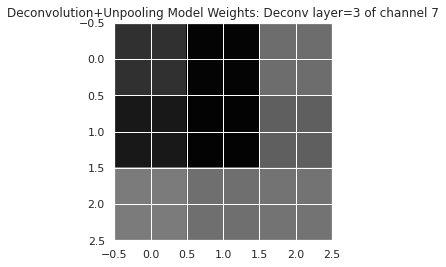

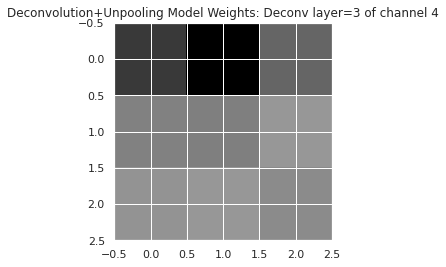

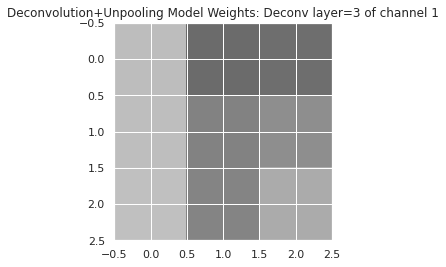

In [95]:
decoder_weights=model_q5_deconv_unpool.decoder_conv3[0].weight.detach().clone()
visualize_deconv_filter(model_q5_deconv_unpool,decoder_weights)